# benchmarking on omnipath


In [1]:
from scprint import scPrint
from scprint.tasks import GNInfer

from bengrn import BenGRN
import scanpy as sc

from bengrn.base import train_classifier

from anndata.utils import make_index_unique
from bengrn import compute_genie3
from grnndata import utils as grnutils
import numpy as np

from scdataloader import Preprocessor

from grnndata import read_h5ad, GRNAnnData
from pyvis import network as pnx

import lamindb as ln

import joblib
%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

→ connected lamindb: jkobject/scprint


In [2]:
model = scPrint.load_from_checkpoint(
    '../data/temp/o2uniqsx/epoch=18-step=133000.ckpt', precpt_gene_emb=None)
#    '../data/temp/vbd8bavn/epoch=19-step=100000.ckpt', precpt_gene_emb=None)
#    '../data/temp/1tghqqzx_dir/epoch=18-step=133000.ckpt', precpt_gene_emb=None)
   # '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', precpt_gene_emb=None)
NUM_GENES = 5000
MAXCELLS = 1024

RuntimeError caught: scPrint is not attached to a `Trainer`.


In [3]:
# mouse neuron
adata = ln.Collection.using(instance="laminlabs/cellxgene").filter(name="cellxgene-census", version='2023-12-15').one().artifacts.filter(key__icontains="5e765f97").one().load()

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/asyncio/sslproto.py:320: ResourceWarning: unclosed transport <asyncio.sslproto._SSLProtocolTransport object at 0x7f172e56b2e0>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)


In [3]:
# t-cell normal human
adata = ln.Collection.using(instance="laminlabs/cellxgene").filter(name="cellxgene-census", version='2023-12-15').one().artifacts.filter(key__icontains="74520626").one().load()

! renewing expired lamin token: call `lamin login <your-handle>` to avoid this
! run input wasn't tracked, call `ln.track()` and re-run


In [7]:
# human normal epithelial (mamary gland here)
adata = ln.Collection.using(instance="laminlabs/cellxgene").filter(name="cellxgene-census", version='2023-12-15').one().artifacts.filter(key__icontains="2ba40233").one().load()

... downloading 2ba40233-8576-4dec-a5f1-2adfa115e2dc.h5ad: 100.0%.. downloading 2ba40233-8576-4dec-a5f1-2adfa115e2dc.h5ad:  0.0%


In [4]:
adata.obs = adata.obs.drop(columns="is_primary_data")
preprocessor = Preprocessor(subset_hvg=3000, skip_validate=True, do_postp=False)
adata = preprocessor(adata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
adata

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 76567 renamining
filtered out 0 cells, 76567 renamining
Removed 0 genes.
startin QC
Seeing 18098 outliers (23.64% of total dataset):
done


AnnData object with n_obs × n_vars = 76567 × 70933
    obs: 'mapped_reference_assembly', 'mapped_reference_annotation', 'alignment_software', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'donor_living_at_sample_collection', 'donor_menopausal_status', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'sample_derivation_process', 'sample_source', 'donor_BMI_at_collection', 'suspension_depleted_cell_types', 'suspension_derivation_process', 'suspension_dissociation_reagent', 'suspension_dissociation_time', 'suspension_percent_cell_viability', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'sequencing_platform', 'cell_type_ontology_term_id', 'author_cell_type', 'cell_state', 'disease_ontology_term_id', 'sex_ontology_term_id', 'n_count_rna', 'n_feature_rna', 'percent_mito', 'percent_rb', 'tissue_location', 'bmi_group', 'procedure_group', 'age_group', 'sample_id

In [5]:
#model.normalization = "log"
model.organisms = ['NCBITaxon:9606','NCBITaxon:10090']
adata.obs.cell_type.value_counts()

cell_type
CD4-positive helper T cell                         24782
CD8-positive, alpha-beta memory T cell             19213
effector memory CD8-positive, alpha-beta T cell     7303
CD4-positive, alpha-beta T cell                     5199
effector memory CD4-positive, alpha-beta T cell     4883
natural killer cell                                 4345
mature NK T cell                                    2867
regulatory T cell                                   2365
activated CD4-positive, alpha-beta T cell           2123
lymphocyte                                          1667
activated CD8-positive, alpha-beta T cell           1032
gamma-delta T cell                                   529
T cell                                               259
Name: count, dtype: int64

In [7]:
adata = adata[(adata.obs.disease=="normal")]

In [8]:
grn_inferer = GNInfer(
                    layer=list(range(model.nlayers))[:],
                    how="most var across",
                    preprocess="softmax",
                    head_agg='mean',
                    filtration="none",
                    forward_mode="none",
                    num_genes=4000,
                    max_cells=1024,
                    num_workers=16,
                    doplot=False,
                    batch_size=16,
                    )
grn = grn_inferer(model, adata[(adata.X.sum(1) > 500)], cell_type="regulatory T cell") #regulatory T cell, glutamatergic neuron, luminal epithelial cell of mammary gland
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index=grn.var['symbol']
#grn.varp['all'] = grn.varp['GRN']
#grn.varp['GRN'] = grn.varp['GRN'][:,:,:].mean(-1)

100%|██████████| 64/64 [12:37<00:00, 11.83s/it]


avg link count: 16064064, sparsity: 1.0
> /home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py(406)save()
    404 
    405         pdb.set_trace()
--> 406         grn = GRNAnnData(
    407             subadata[:, subadata.var.index.isin(self.curr_genes)].copy(), grn=grn
    408         )



In [9]:
## plots:
#grn.write_h5ad("../data/temp/mouse_neur.h5ad") #Fezf2
#grn.write_h5ad("../data/temp/reg_t_cell_human.h5ad") #LEF1
#grn.write_h5ad("../data/temp/epithelial_human.h5ad") #CEACAM1


In [10]:
#grn = read_h5ad("../data/temp/mouse_neur.h5ad") #Fezf2
grn = read_h5ad("../data/temp/reg_t_cell_human.h5ad") #LEF1
#grn = read_h5ad("../data/temp/epithelial_human.h5ad") #CEACAM1
gene = "LEF1"
grn.grn.loc[gene].max()

0.023390712

In [11]:
grn = grn[:, ~grn.var.index.isna()]
grn = GRNAnnData(grn.copy(), grn=grn.varp['GRN'])

['#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e'] Index(['HNRNPA1L3', 'SRGN', 'RYR2', 'ZBED6', 'CD3D', 'SLC25A6', 'FDCSP',
       'HLA-DQA2', 'MUCL1', 'MZB1', 'ANKRD12', 'HLA-DQB2', 'B2M', 'CGA',
       'PARP9', 'ZNRF2', 'RESF1', 'HLA-DRB5', 'CD3E', 'HELLS', 'CDK16',
       'POU5F2', 'S100A9', 'NQO1', 'DUSP4', 'IL24', 'C4orf3', 'CRLF2', 'RPS7',
       'ENPEP', 'SPP1', 'CPE', 'HLA-DMB', 'CIDEA', 'SELL', 'TIMM23', 'NFAM1',
       'CD2', 'HSP90AA1', 'PRDX4', 'MRPL18', 'PHLDA2', 'RPS8', 

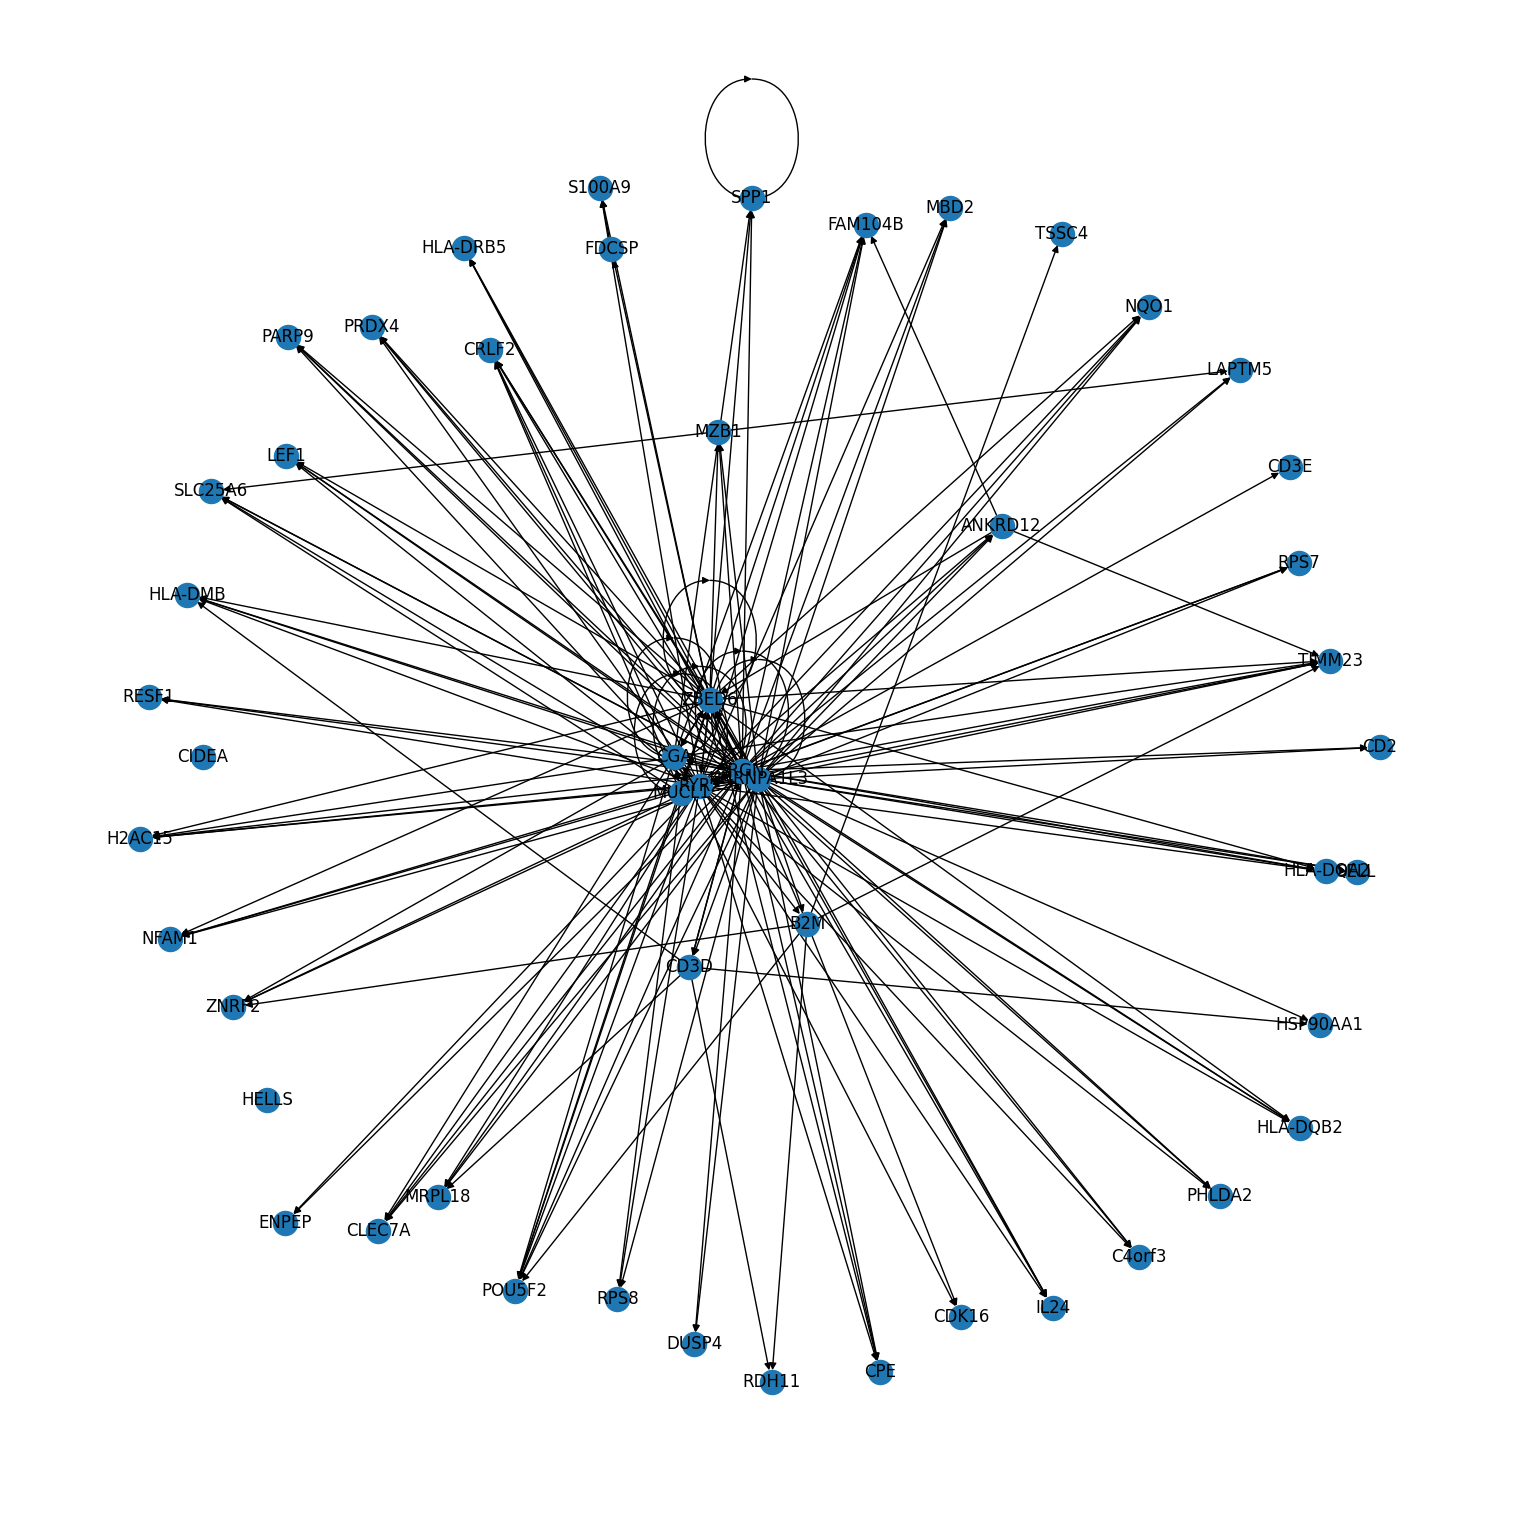

In [12]:
G = grn.plot_subgraph(gene, max_genes=50, only=180, interactive=False)

In [14]:
from IPython.display import display, HTML

color1 = "#114101"
color2 = "#79435d"
color3 = "#44028a"
display(HTML(f'<div style="width:100px;height:100px;background-color:{color3};"></div>'))

In [15]:
pnet = pnx.Network(notebook=False, cdn_resources="in_line", directed=True)
pnet.prep_notebook()

In [16]:
# Set one node to color red
pnet.from_nx(G)
first_node = list(G.nodes)[-1]
pnet.get_node(first_node)['color'] = "red"
for i in list(G.nodes)[:-1]:
    pnet.get_node(i)['color'] = color3

pnet.toggle_physics(True)
pnet.show_buttons(filter_=['physics'])
pnet.show("temp.html")

temp.html
